In [1]:
import os
import os.path, time
import pandas as pd
import numpy as np
from numpy.random import seed
seed(1)
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
from cycle_prediction.t2e import t2e
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
palette=sns.color_palette("RdBu_r", 50)
import pickle
import random
import warnings
warnings.filterwarnings("ignore")
plt.style.use('seaborn-muted')
%matplotlib inline
%load_ext autoreload
%autoreload 2
import h5py


pd.set_option('display.max_rows', None)
range_dict = {
    'a': range(2,8,1),
    'b': range(2,22,2),
    'c': range(2,12,2),
    'd': range(2,22,2),
    'a_complete': range(2,8,1),
    'b_complete': range(2,22,2),
    'c_complete': range(2,12,2),
    'd_complete': range(2,22,2),
    'a_reduced': range(2,8,1),
    'b_reduced': range(2,22,2),
    'c_reduced': range(2,12,2),
    'd_reduced': range(2,22,2),
}

path = '../data/'

a = os.path.join(path,'helpdesk.csv')
a = pd.read_csv(a)
b = os.path.join(path,'bpi_12_w.csv')
b = pd.read_csv(b)
c = os.path.join(path,'bpi_12_w_no_repeat.csv')
c = pd.read_csv(c)
d = os.path.join(path,'env_permit.csv')
d = pd.read_csv(d)

df_name = {
    'a':'helpdesk',
    'b':'bpi_12_w',
    'c':'bpi_12_w_no_repeat',
    'd':'env_permit'
}

df_dict = {
    'a': a,
    'b': b,
    'c': c,
    'd': d
}


C:\Users\ebasfad\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


[]

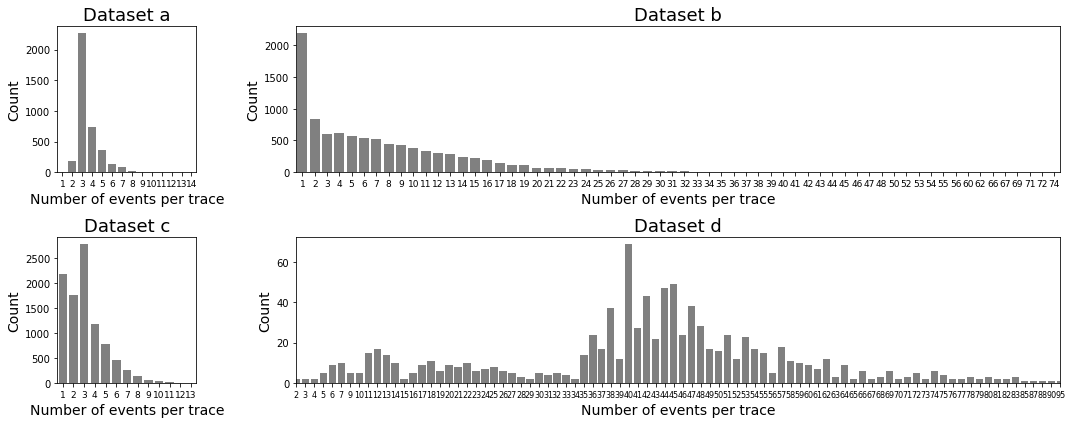

In [2]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[2,11])

i = 0
for key, dataset in df_dict.items():

    ax = plt.subplot(gs[i])
    sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'count'})["ActivityID"], color='gray', ax = ax)
    if key == 'd':
        plt.xticks(rotation=0, fontsize=8)
        plt.xlim((0,85))
    else:
        plt.xticks(rotation=0, fontsize=9)
    plt.xlabel("Number of events per trace", fontsize=14)
    plt.ylabel("Count",fontsize=14)
    plt.title("Dataset " + key,fontsize=18)
    i+=1
plt.tight_layout()
plt.plot()

[]

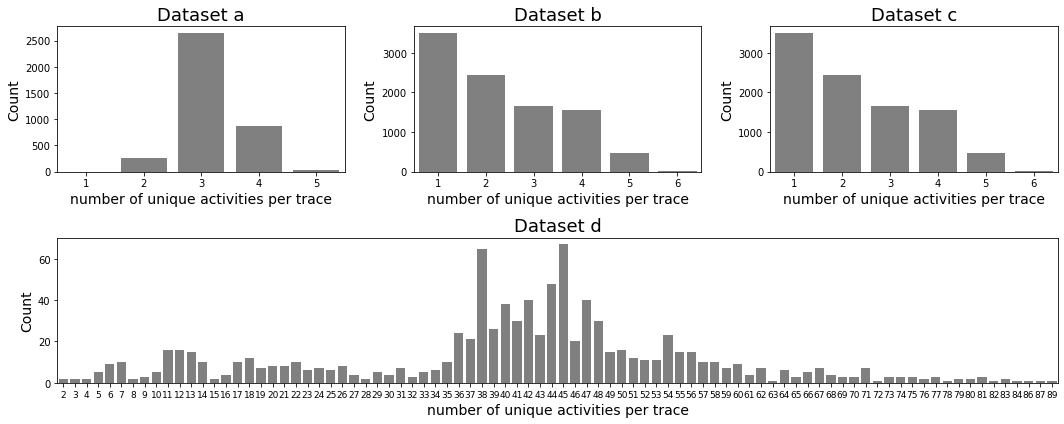

In [3]:
fig = plt.figure(figsize=(15, 6)) 
gs = gridspec.GridSpec(2, 3, width_ratios=[1,1,1])

i = 0
for key, dataset in df_dict.items():

    ax = plt.subplot(gs[i])
    if i == 3:
        ax = plt.subplot(gs[i:])
        plt.xlim((0,85))
        plt.xticks(rotation=0, fontsize=9)
    sns.countplot(dataset.groupby(["CaseID"]).agg({"ActivityID":'nunique'})["ActivityID"], color='gray', ax = ax)
    plt.xlabel("number of unique activities per trace", fontsize=14)
    plt.ylabel("Count",fontsize=14)
    plt.title("Dataset " + key,fontsize=18)
    i+=1
plt.tight_layout()
plt.plot()

In [4]:
## Evaluate baseline results and save to pickle file

path_baseline_results = '../output/maes/baseline/'

a_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_helpdesk.csv')
b_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w.csv')
c_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w_no_repeat.csv')
d_complete = os.path.join(path_baseline_results,'suffix_and_remaining_time_env_permit.csv')

a_complete = pd.read_csv(a_complete)
b_complete = pd.read_csv(b_complete)
c_complete = pd.read_csv(c_complete)
d_complete = pd.read_csv(d_complete)

a_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_helpdesk_reduced.csv')
b_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w_reduced.csv')
c_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_bpi_12_w_no_repeat_reduced.csv')
d_reduced = os.path.join(path_baseline_results,'suffix_and_remaining_time_env_permit_reduced.csv')

for file in [a_reduced, b_reduced,c_reduced,d_reduced]:
    print("Last modified: %s" % time.ctime(os.path.getmtime(file)))

a_reduced = pd.read_csv(a_reduced)
b_reduced = pd.read_csv(b_reduced)
c_reduced = pd.read_csv(c_reduced)
d_reduced = pd.read_csv(d_reduced)


df_dict = {
    'a_complete': a_complete,
    'b_complete': b_complete,
    'c_complete': c_complete,
    'd_complete': d_complete,
    'a_reduced': a_reduced,
    'b_reduced': b_reduced,
    'c_reduced': c_reduced,
    'd_reduced': d_reduced
}

for dataset in df_dict.keys():
    tmp = df_dict[dataset].groupby(["Prefix length"]).apply(lambda x:mean_absolute_error(x['Ground truth times'], x['Predicted times'])/86400).to_dict()
    tmp = {k:v for k,v in tmp.items() if k in list(range_dict[dataset])}
    pickle.dump(list(tmp.values()), open(path_baseline_results + dataset +'.pkl', "wb"))

Last modified: Thu Oct  1 03:39:22 2020
Last modified: Thu Oct  1 03:39:22 2020
Last modified: Thu Oct  1 03:39:22 2020
Last modified: Thu Oct  1 03:39:22 2020


In [5]:
train_time = {
    'baseline':{
        'a':2462.0/60,
        'b':12638.0/60,
        'c':4140.0/60,
        'd':8209.0/60
    },
#     'regression':{
#         dataset:pickle.load(open('output/maes/regression/0/' +'regression_'+dataset+'_reduced.pkl', 'rb'))['fit_time'].sum()/60.0 for dataset in ['a','b','c','d']
#     },
    't2e':{
        dataset:pickle.load(open('../output/maes/t2e/0/' +'t2e_'+dataset+'_reduced.pkl', 'rb'))['fit_time'].sum()/60.0 for dataset in ['a','b','c','d']
    }
}

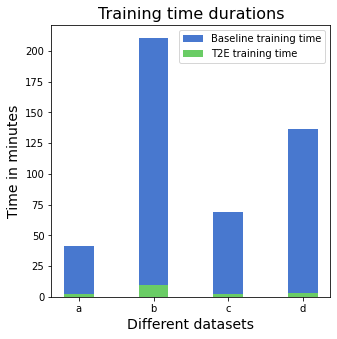

In [6]:
plt.figure(figsize=(5,5));
plt.bar(train_time['baseline'].keys(),train_time['baseline'].values(), label='Baseline training time', width=0.4 );
plt.bar(train_time['t2e'].keys(),train_time['t2e'].values(), label='T2E training time', width=0.4);
plt.ylabel("Time in minutes", fontsize=14);
plt.xlabel("Different datasets", fontsize=14);
plt.title('Training time durations', fontsize=16);
plt.legend();

In [20]:
# result_dict = {}
# plt.style.use('seaborn-deep')
# path = 'output/maes/t2e_transform/'

# for data in ['a']:
#     dataset_censored = pd.DataFrame()
#     for folder in ["10","20","30","40","50","60","70","80","90"]:

#         dataset_censored = dataset_censored.append(pickle.load(open(path + folder + '/t2e_'+data+'_censored.pkl','rb')),ignore_index=True)
        
#     dataset_censored['type'] = 'Censored'
#     dataset = dataset_censored.copy()
#     dataset["Censored %"] = np.round(dataset["Censored %"],decimals=1)

#     dataset = dataset.sort_values(['prefix','Censored %','type','MAE'])\
#                                 .drop_duplicates(subset=['prefix','Censored %','type'], keep='first')\
#                                 .reset_index(drop=True)
    
#     mode = dataset['Censored %'].value_counts().mode()[0]
#     dataset = dataset = dataset[dataset.groupby("Censored %")["Censored %"].transform('size') == mode]
#     result_dict[data] = dataset
    
#     plt.figure(figsize=(12,6));
#     g = sns.catplot(data=dataset, x='Censored %', y ='MAE', hue='type', col='prefix', kind='bar');
    
#     print(type(g))
    
#     plt.show();
#     print(data, dataset['MAE'].min())

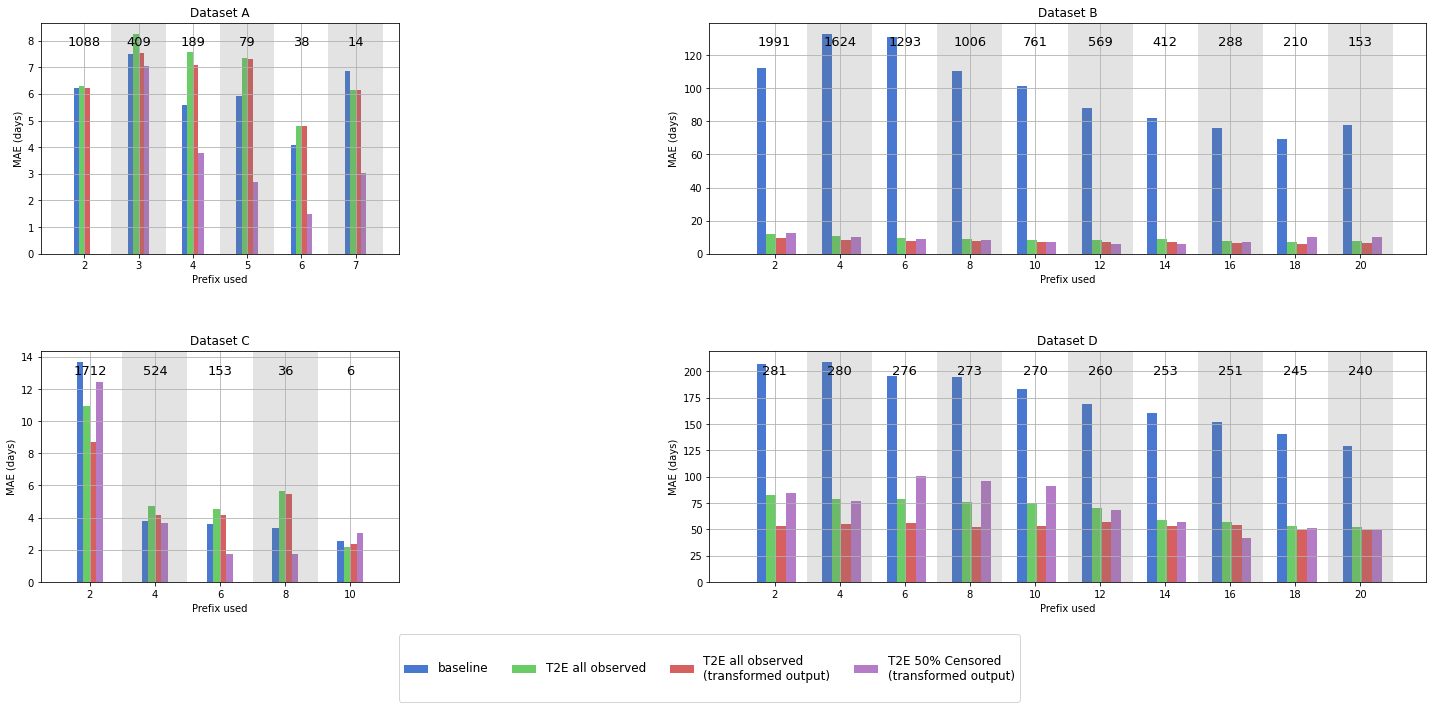

In [7]:
from matplotlib import gridspec

fig = plt.figure(figsize=(20, 10)) 
gs = gridspec.GridSpec(2, 2, width_ratios=[1,2])
p = 0
for dataset in ['a','b','c','d']:
    cases = []
    labels= []

    ## Load baseline:
    path_baseline_complete = '../output/maes/baseline/0/'
#     baseline_reduced  = pickle.load(open(path + dataset +'_reduced.pkl', 'rb'))
    baseline_complete = pickle.load(open(path_baseline_complete + dataset +'_complete.pkl', 'rb'))
    cases.append(baseline_complete)
    labels.append("\nbaseline\n")
    
    
    ## Load grid search results complete
    path_t2e_complete = '../output/maes/t2e/0/'
    grid_results_t2e_complete = list(np.squeeze(pickle.load(open(path_t2e_complete + 't2e_'+dataset+'_GRU.pkl', 'rb')).groupby(["prefix"]).agg({"MAE":"min"}).values))
    cases.append(grid_results_t2e_complete)
    labels.append("\nT2E all observed\n")

    path_t2e_complete_trans = '../output/maes/t2e_transform/0/'
    grid_results_t2e_transform = list(np.squeeze(pickle.load(open(path_t2e_complete_trans + 't2e_'+dataset+'_GRU.pkl', 'rb')).groupby(["prefix"]).agg({"MAE":"min"}).values))
    cases.append(grid_results_t2e_transform)
    labels.append("\nT2E all observed\n(transformed output)\n")

    
    ## Load grid search results censored transform
    path_t2e_50_trans = '../output/maes/t2e_transform/50/'
    grid_results_t2e_censored_trans = list(np.squeeze(pickle.load(open(path_t2e_50_trans + 't2e_'+dataset+'_GRU.pkl', 'rb')).groupby(["prefix"]).agg({"MAE":"min"}).values))
    cases.append(grid_results_t2e_censored_trans)
    labels.append("\nT2E 50% Censored\n(transformed output)\n")
    
    
    ax = plt.subplot(gs[p])
    X = np.array(range_dict[dataset])
    for j,case in enumerate(cases):
        
        if dataset in ['a']:
            cases[3][0] = 0
            steps = [-0.15, -0.05, 0.05, 0.15]
            width = 0.1
        elif dataset in ['c']:
            steps = [-0.3,-0.1, 0.1, 0.3]
            width =0.2
        else:
            steps = [-0.4,-0.1, 0.2, 0.5]
            width=0.3
            
        ax.bar(
            x      = X + steps[j], 
            height = case,
            width  = width,
            label  = labels[j]
        );

    text_counts = pickle.load(open(path_t2e_complete + 't2e_'+dataset+'_GRU.pkl', 'rb'))\
                                .sort_values(['prefix','MAE'])\
                                .drop_duplicates(subset=['prefix'], keep='first')\
                                .reset_index(drop=True)\
                                ["test_size"]\
                                .values
    
    
    for i, span in enumerate(X):
        if dataset == 'a':
            ax.axvspan(span-0.5, span+0.5, facecolor='#767676', alpha=(i%2)*0.2)
        else:
            ax.axvspan(span-1, span+1, facecolor='#767676', alpha=(i%2)*0.2)
        ax.text(span,ax.get_ylim()[1]-10*ax.get_ylim()[1]/100,'{:1.0f}'.format(text_counts[i]),ha="center", fontsize=13);

    ax.set_xticks(range_dict[dataset])
    ax.set_xlabel("Prefix used")
    ax.set_ylabel("MAE (days)")
    ax.set_title("Dataset " + dataset.upper())
    ax.grid()
    p+=1


ax.legend(loc='upper center', bbox_to_anchor=(0.0, -0.2) , ncol=4, frameon = True, fancybox =True, shadow = False, framealpha=0.8,fontsize=12)
# plt.subplots_adjust(right=0.85)

plt.style.use('seaborn-deep')
gs.tight_layout(fig,h_pad=5, w_pad=0)
plt.show()